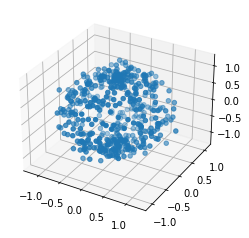

In [19]:
from matplotlib import pyplot as plt
import numpy as np

def decoder(data):
    x = 1 * torch.sin(data[:,:,0])*torch.cos(data[:,:,1])
    y = 1 * torch.sin(data[:,:,0])*torch.sin(data[:,:,1])
    z = 1 * torch.cos(data[:,:,0])
    
    return torch.cat([x,y,z])

n = 500
theta = np.random.uniform(0, 2*np.pi, n)
phi = np.random.uniform(0, np.pi, n)

r = np.random.normal(1, 0.1, n)

x = r * np.sin(theta)*np.cos(phi)
y = r * np.sin(theta)*np.sin(phi)
z = r * np.cos(theta)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(x, y, z)

plt.show()

In [3]:
import torch

In [77]:
from stochman import manifold, geodesic, utilities
from stochman.curves import BasicCurve, CubicSpline

class geoDecoder(manifold.EmbeddedManifold):
    def __init__(self, decoder, **kwargs):
        super(geoDecoder).__init__(**kwargs)
        self.decoder = decoder

    def embed(self, points): # works for only 1 image in batch
        #print('Curve points shape', points.shape)
        
        B = points.shape[0]
        N = points.shape[1]
        decode = self.decoder(points)
        #print('After decoder shape', decode.shape)
        decode = decode.reshape([B, N, -1])
        #print('After reshaping shape', decode.shape)

        return decode
    
    def curve_energy(self, curve: BasicCurve, dt=None):
        """
        Compute the discrete energy of a given curve.
        Input:
            curve:      a Nx(d) torch Tensor representing a curve or
                        a BxNx(d) torch Tensor representing B curves.
        Output:
            energy:     a scalar corresponding to the energy of
                        the curve (sum of energy in case of multiple curves).
                        It should be possible to backpropagate through
                        this in order to compute geodesics.
        Algorithmic note:
            The algorithm rely on the deterministic embedding of the manifold
            rather than the metric. This is most often more efficient.
        """
        if curve.dim() == 2:
            curve.unsqueeze_(0)  # add batch dimension if one isn't present
        if dt is None:
            dt = curve.shape[1] - 1
            
        # Now curve is BxNx(d)
        emb_curve = self.embed(curve)  # BxNxD
        B, N, D = emb_curve.shape
        delta = emb_curve[:, 1:, :] - emb_curve[:, :-1, :]  # Bx(N-1)xD
        energy = (delta ** 2).sum((1, 2)) * dt  # B
        
        #print(energy) # to see value going down
        
        return energy
    
    def connecting_geodesic(self, p0, p1, init_curve = None):
        """
        Compute geodesic connecting two points.
        Args:
            p0: a torch Tensor representing the initial point of the requested geodesic.
            p1: a torch Tensor representing the end point of the requested geodesic.
            init_curve: a curve representing an initial guess of the requested geodesic.
                If the end-points of the initial curve do not correspond to p0 and p1,
                then the curve is modified accordingly. If None then the default constructor
                of the chosen curve family is applied.
        """
        if init_curve is None:
            curve = CubicSpline(p0, p1)
        else:
            curve = init_curve
            curve.begin = p0
            curve.end = p1

        #success = geodesic.geodesic_minimizing_energy_sgd(curve, self)
        success = geodesic_minimizing_energy(curve, self, eval_grid=25, max_iter = 400)
        return curve, success

    
def geodesic_minimizing_energy(curve, manifold, optimizer=torch.optim.Adam, max_iter=150, eval_grid=20):
    """
    Compute a geodesic curve connecting two points by minimizing its energy.
    Mandatory inputs:
        curve:      A curve object representing a curve with fixed end-points.
                    When the function returns, this object has been updated to
                    be a geodesic curve.
        manifold:   A manifold object representing the space over which the
                    geodesic is defined. This object must provide a
                    'curve_energy' function through which pytorch can
                    back-propagate.
    Optional inputs:
        optimizer:  Choice of iterative optimizer.
                    Default: torch.optim.Adam
        max_iter:   The maximum number of iterations of the optimizer.
                    Default: 150
        eval_grid:  The number of points along the curve where
                    energy is evaluated.
                    Default: 20
    Output:
        success:    True if the algorithm converged, False otherwise.
    Example usage:
    S = Sphere()
    p0 = torch.tensor([0.1, 0.1]).reshape((1, -1))
    p1 = torch.tensor([0.3, 0.7]).reshape((1, -1))
    C = CubicSpline(begin=p0, end=p1, num_nodes=8, requires_grad=True)
    geodesic_minimizing_energy(C, S)
    """
    # Initialize optimizer and set up closure
    
    alpha = torch.linspace(0, 1, eval_grid, dtype=curve.begin.dtype, device=curve.device)

    opt = optimizer(curve.parameters(), lr=1)

    def closure():
        opt.zero_grad()
        loss = manifold.curve_energy(curve(alpha)).mean()
        loss.backward()
        return loss

    thresh = 1e-3

    for k in range(max_iter):
        opt.step(closure=closure)
        max_grad = max([p.grad.abs().max() for p in curve.parameters()])
        if max_grad < thresh:
            break
        # if k % (max_iter // 10) == 0:
        #    curve.constant_speed(manifold)
    #curve.constant_speed(manifold)
    return max_grad < thresh

In [78]:
geom = geoDecoder(decoder = decoder)

In [79]:
a = torch.tensor([0, np.pi/4])
b = torch.tensor([3*np.pi/4, np.pi/4])

curve, success = geom.connecting_geodesic(a, b)

In [80]:
success

tensor(False)

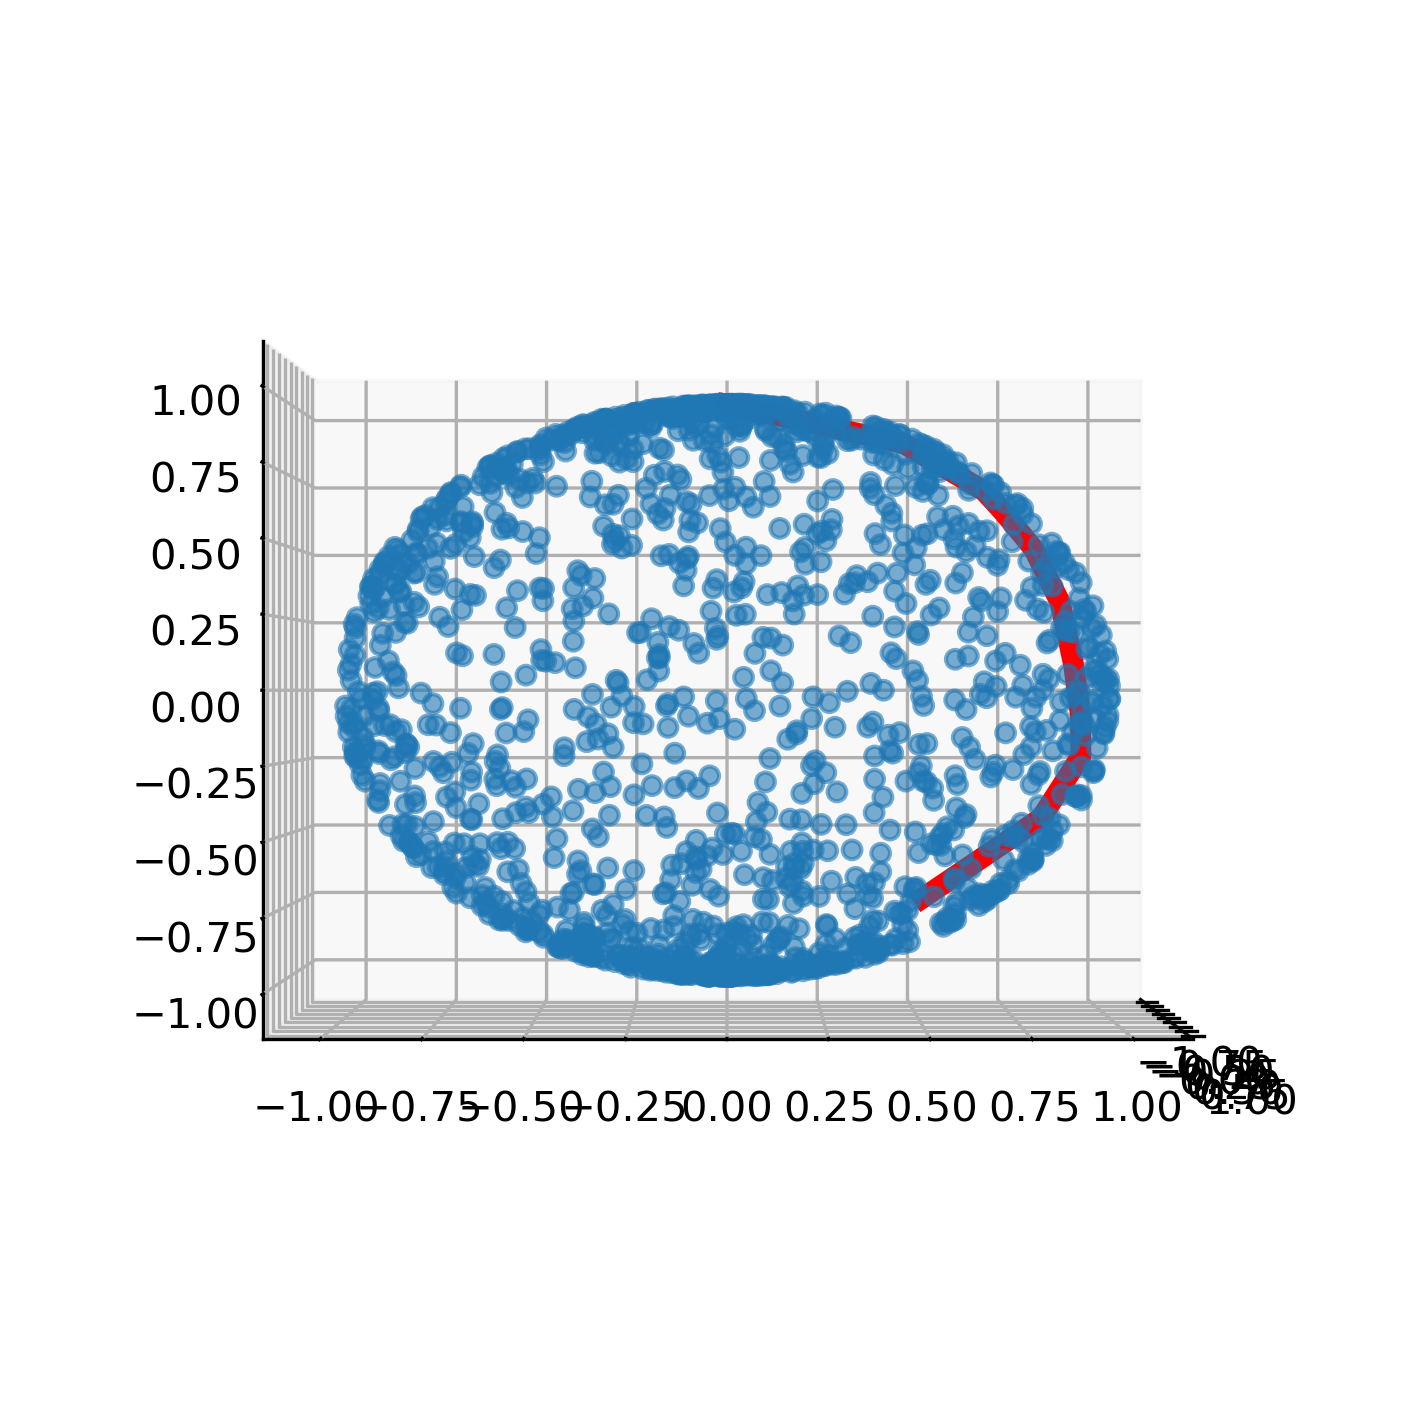

In [84]:
a_ = torch.cat([torch.ones(1,1)*i/10 for i in range(11)], axis=1)
cp = curve.forward(a_)

out = decoder(cp).detach().cpu().numpy()

fig = plt.figure(figsize = (6,6), dpi=300)
ax = fig.add_subplot(projection="3d")

n = 1500
theta = np.random.uniform(0, 2*np.pi, n)
phi = np.random.uniform(0, np.pi, n)

r = np.random.normal(1, 0.001, n)

x = r * np.sin(theta)*np.cos(phi)
y = r * np.sin(theta)*np.sin(phi)
z = r * np.cos(theta)

ax.scatter(x, y, z, alpha=0.6)
ax.plot(out[0,:], out[1,:], out[2,:], color='red', linewidth = 5)
ax.view_init(0, 0)

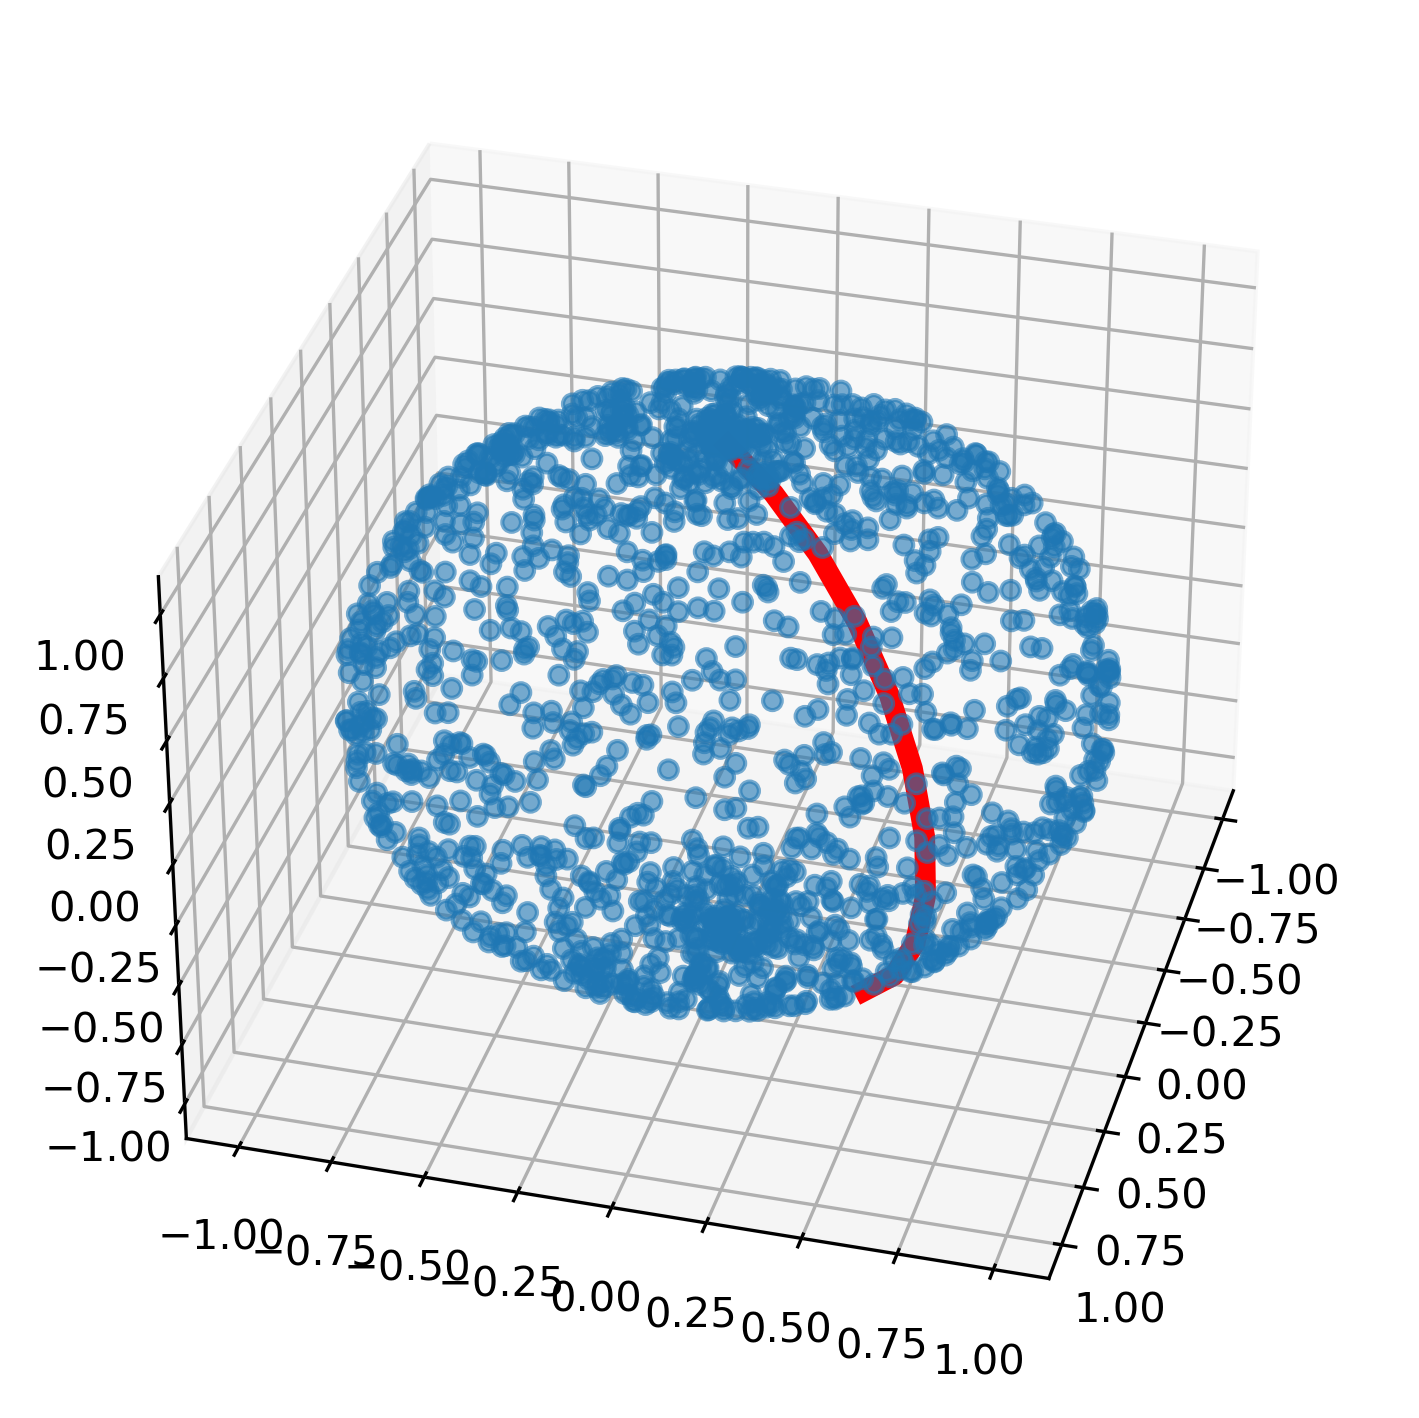

In [94]:
curve = CubicSpline(a, b)
cp = curve.forward(a_)

out = decoder(cp).detach().cpu().numpy()

fig = plt.figure(figsize = (6,6), dpi=300)
ax = fig.add_subplot(projection="3d")

n = 1500
theta = np.random.uniform(0, 2*np.pi, n)
phi = np.random.uniform(0, np.pi, n)

r = np.random.normal(1, 0.001, n)

x = r * np.sin(theta)*np.cos(phi)
y = r * np.sin(theta)*np.sin(phi)
z = r * np.cos(theta)

ax.scatter(x, y, z, alpha=0.6)
ax.plot(out[0,:], out[1,:], out[2,:], color='red', linewidth = 5)
ax.view_init(33, 15)

In [58]:
%matplotlib widget
# aka import ipympl

import matplotlib.pyplot as plt

plt.plot([0, 1, 2, 2])
plt.show()


<IPython.core.display.Javascript object>